# Multiple output from LSTM model

## Operator 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM # type: ignore
from sklearn.preprocessing import MinMaxScaler

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

### Processing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []
    mae_list = []

    for i in range(len(y_pred)):
        mae = []
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])
            mae.append(np.abs(y_pred[i][k] - y_true[i][k]))
        mae_list.append(mae)

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.array(mae_list)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results


'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_out} Timesteps Ahead -- {operator}', fontsize=16, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return means

### Overlapping campaigns

- Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode

- Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode, Capacity_Ookla_4G5G_Vodafone_Driving_Viale_Marconi, (Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode)

- Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense, Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense, (Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode), (Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2)

- Ping_UNIDATA_4G5G_Vodafone_Driving_Luca, Interactivity_gaming_4G5G_Vodafone_Driving_Luca, Capacity_Ookla_4G5G_Vodafone_Driving_Luca

### Parameters

In [5]:
tf.random.set_seed(4567)

# LSTM
n_steps_in = 5
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
min_leaf_size = 5

In [6]:
overlap_1 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Viale_Marconi', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

overlap_3 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2']

overlap_4 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Luca', 
             'Interactivity_gaming_4G5G_Vodafone_Driving_Luca', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Luca']

In [7]:
train = read_dataset('datasets/Op2_merged.csv', campaigns=[overlap_1[1]])
test = read_dataset('datasets/Op2_merged.csv', campaigns=[overlap_1[0]])
operator = 'Operator 2'

In [8]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                    #  ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

feature_comb = ['RSRP, SINR, RSRQ -> RSRP', 'RSRP, SINR, RSRQ -> SINR', 'RSRP, SINR, RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR', 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ']

## 2 Steps prediction

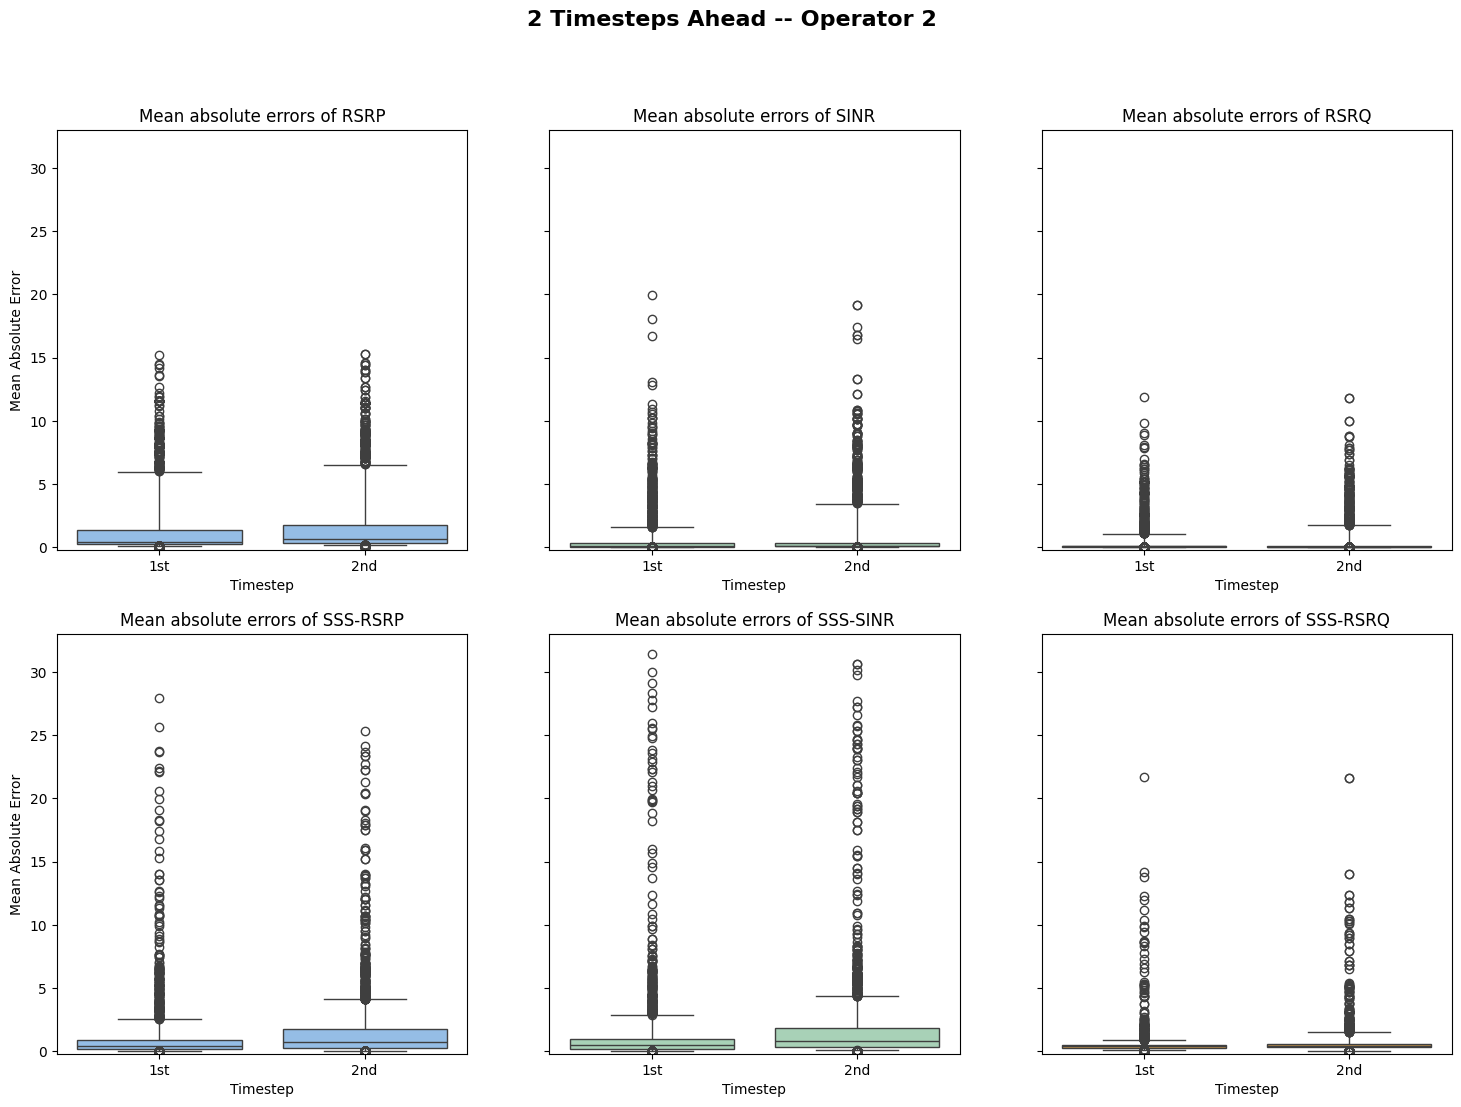

In [9]:
n_steps_in = 2
n_steps_out = 2

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

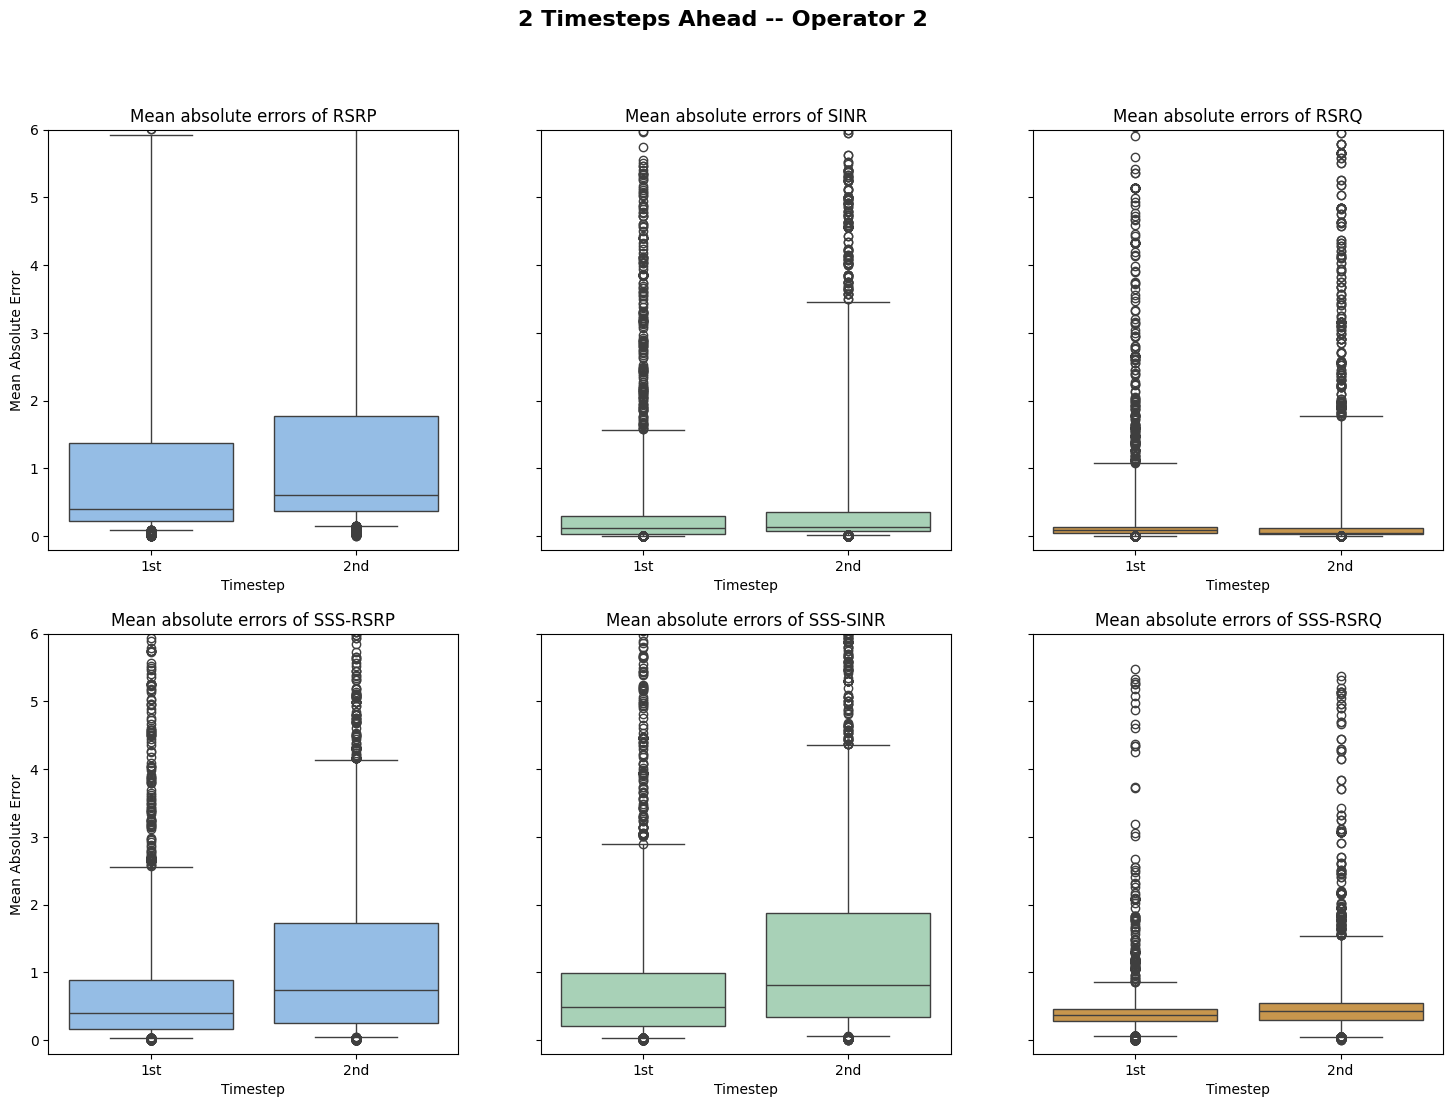

In [10]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator, y_lim=6)

In [11]:
mae_each_step

,1st,2nd
RSRP,1.373,1.606
SINR,0.411,0.605
RSRQ,0.249,0.329
SSS-RSRP,0.814,1.373
SSS-SINR,0.934,1.484
SSS-RSRQ,0.453,0.585


## 3 Steps Prediction

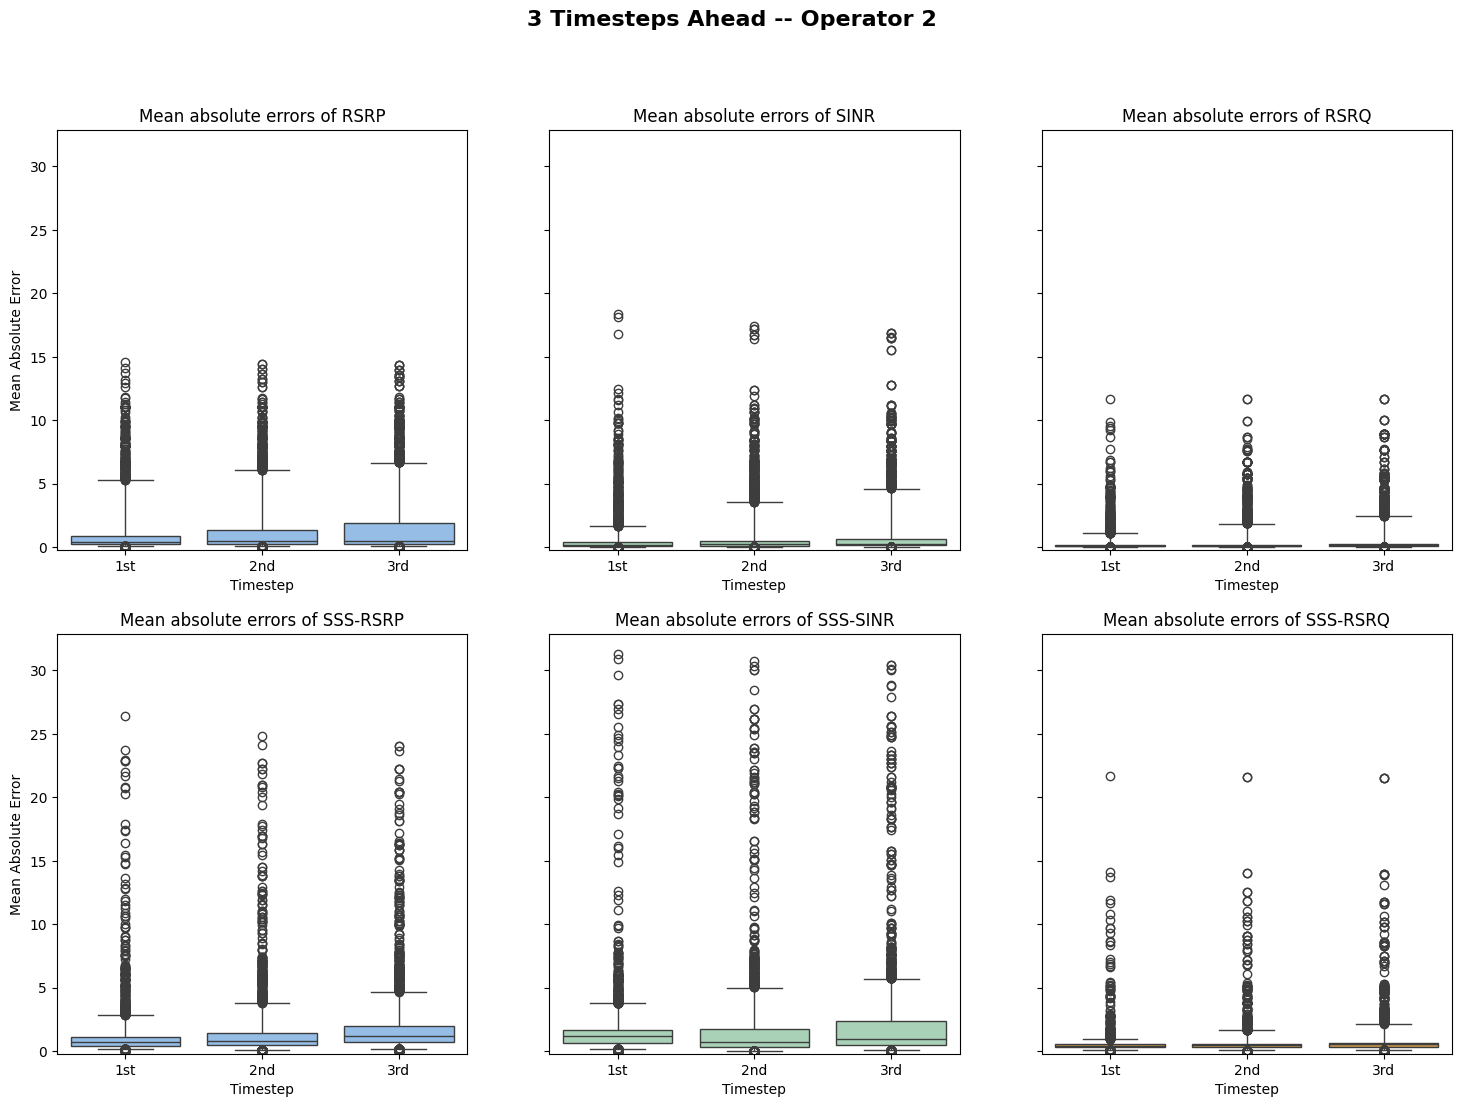

In [12]:
n_steps_in = 3
n_steps_out = 3

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

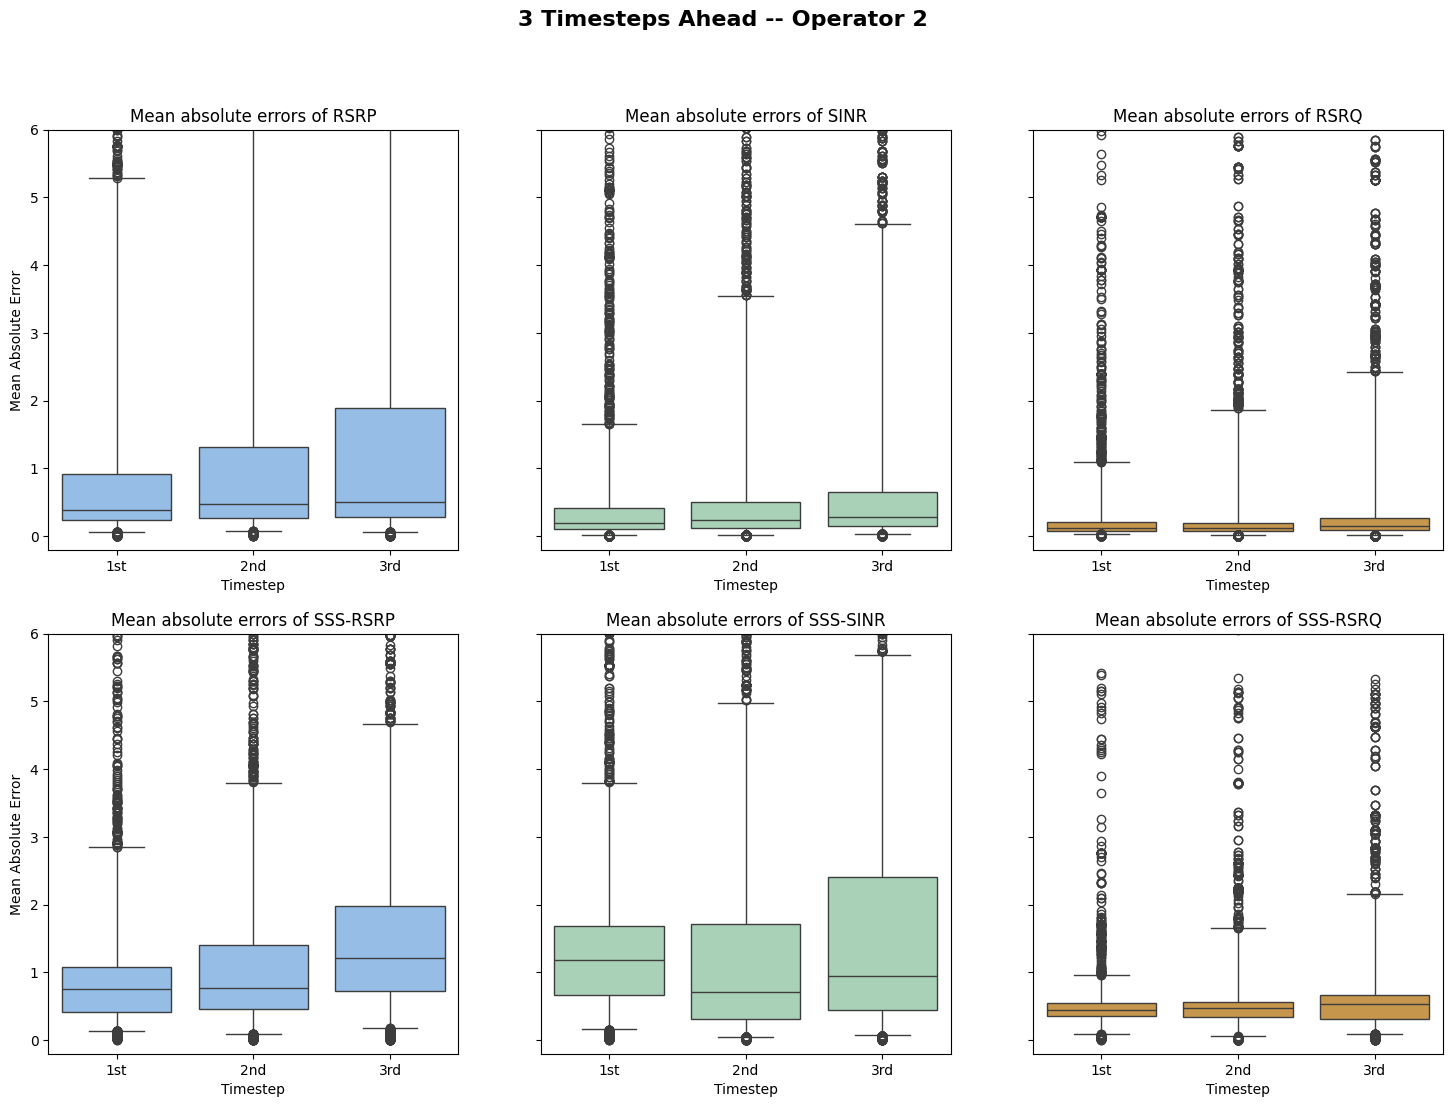

In [13]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator, y_lim=6)

In [14]:
mae_each_step

,1st,2nd,3rd
RSRP,1.122,1.332,1.534
SINR,0.504,0.714,0.903
RSRQ,0.288,0.394,0.516
SSS-RSRP,1.031,1.323,1.769
SSS-SINR,1.472,1.516,1.918
SSS-RSRQ,0.530,0.623,0.730


## 5 Steps Prediction

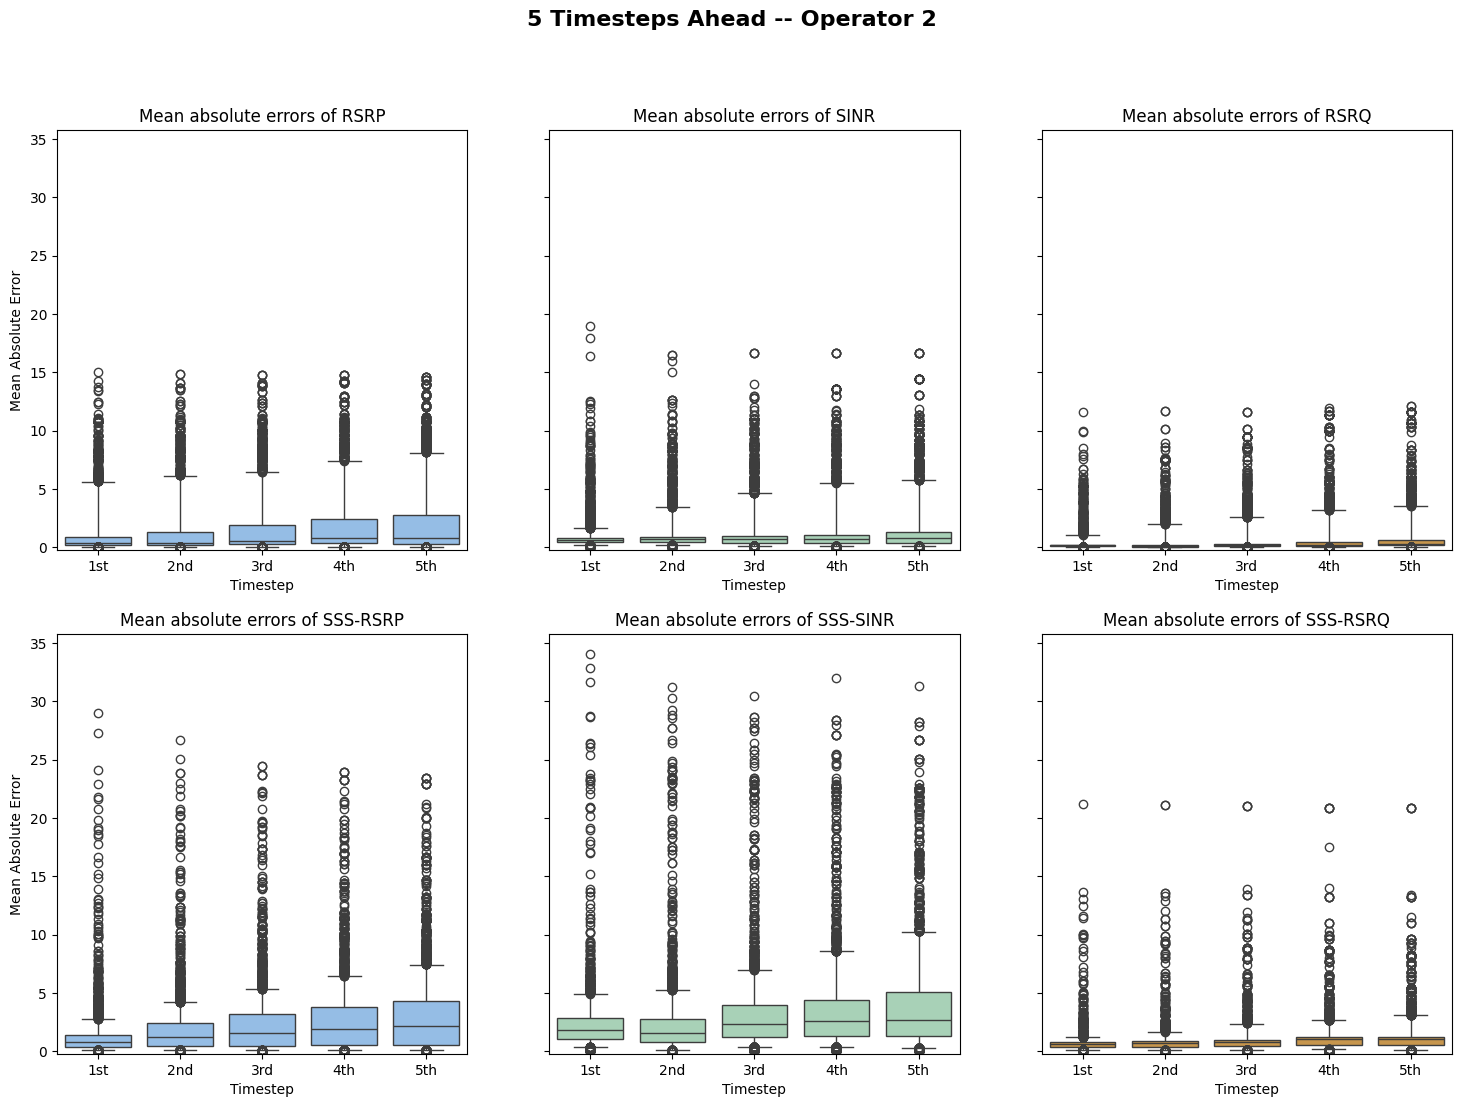

In [15]:
n_steps_in = 5
n_steps_out = 5

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

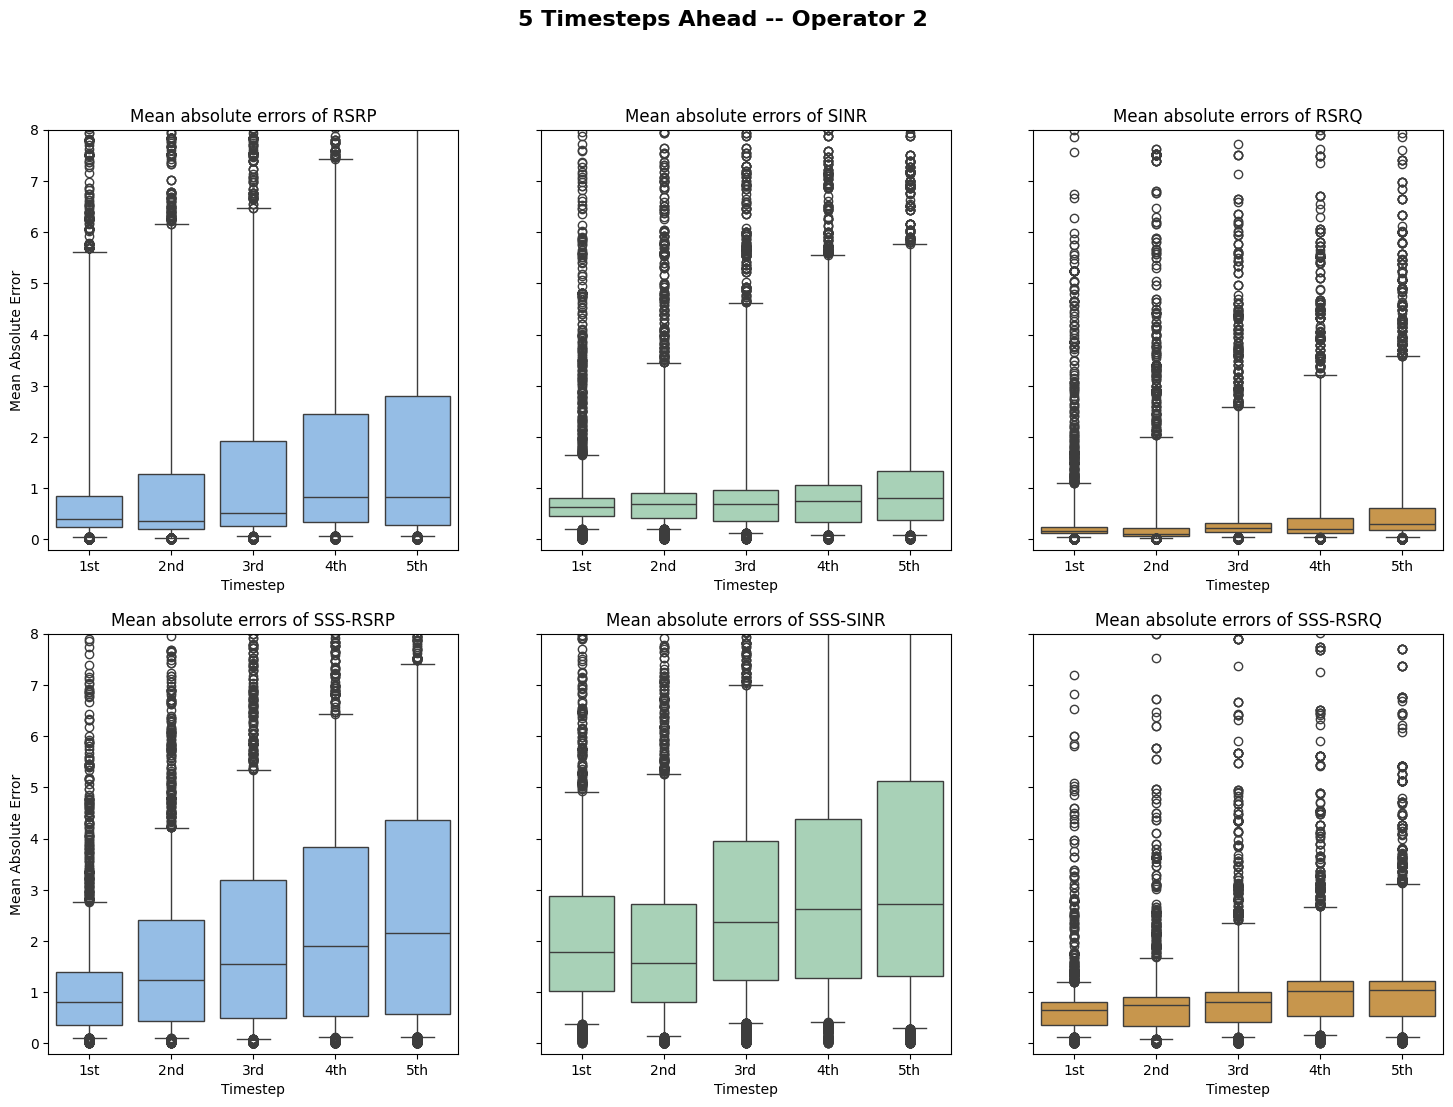

In [16]:
mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator, y_lim=8)

In [17]:
mae_each_step

,1st,2nd,3rd,4th,5th
RSRP,1.138,1.311,1.550,1.849,2.001
SINR,0.810,0.995,1.129,1.293,1.482
RSRQ,0.336,0.424,0.576,0.659,0.779
SSS-RSRP,1.113,1.703,2.200,2.566,2.869
SSS-SINR,2.172,2.135,2.989,3.353,3.729
SSS-RSRQ,0.679,0.785,0.915,1.094,1.139


## 10 Steps Prediction

Different steps back

### 1 step back

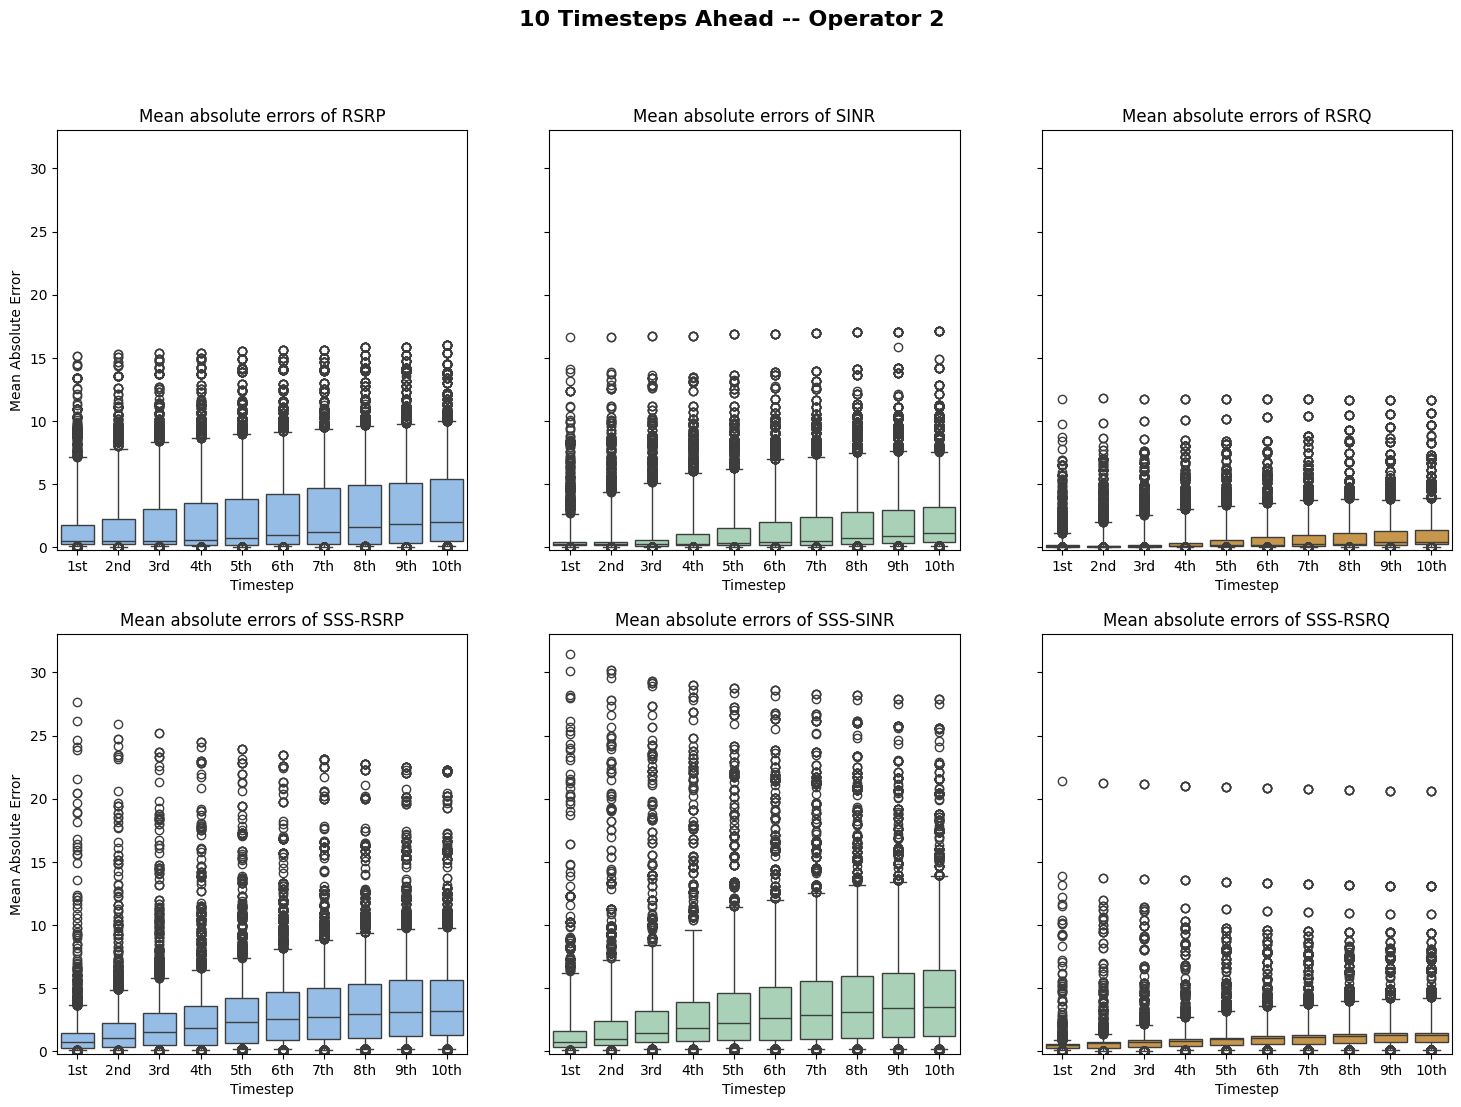

In [18]:
n_steps_in = 1
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [19]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.643,1.819,2.002,2.152,2.329,2.525,2.696,2.888,3.038,3.226
SINR,0.614,0.788,0.969,1.181,1.327,1.561,1.713,1.929,2.118,2.233
RSRQ,0.268,0.352,0.459,0.569,0.668,0.760,0.836,0.919,0.994,1.059
SSS-RSRP,1.189,1.652,2.133,2.495,2.850,3.147,3.446,3.620,3.809,3.840
SSS-SINR,1.531,2.040,2.551,2.956,3.364,3.681,3.986,4.244,4.383,4.566
SSS-RSRQ,0.499,0.661,0.802,0.931,1.046,1.159,1.250,1.324,1.389,1.425


### 2 steps back

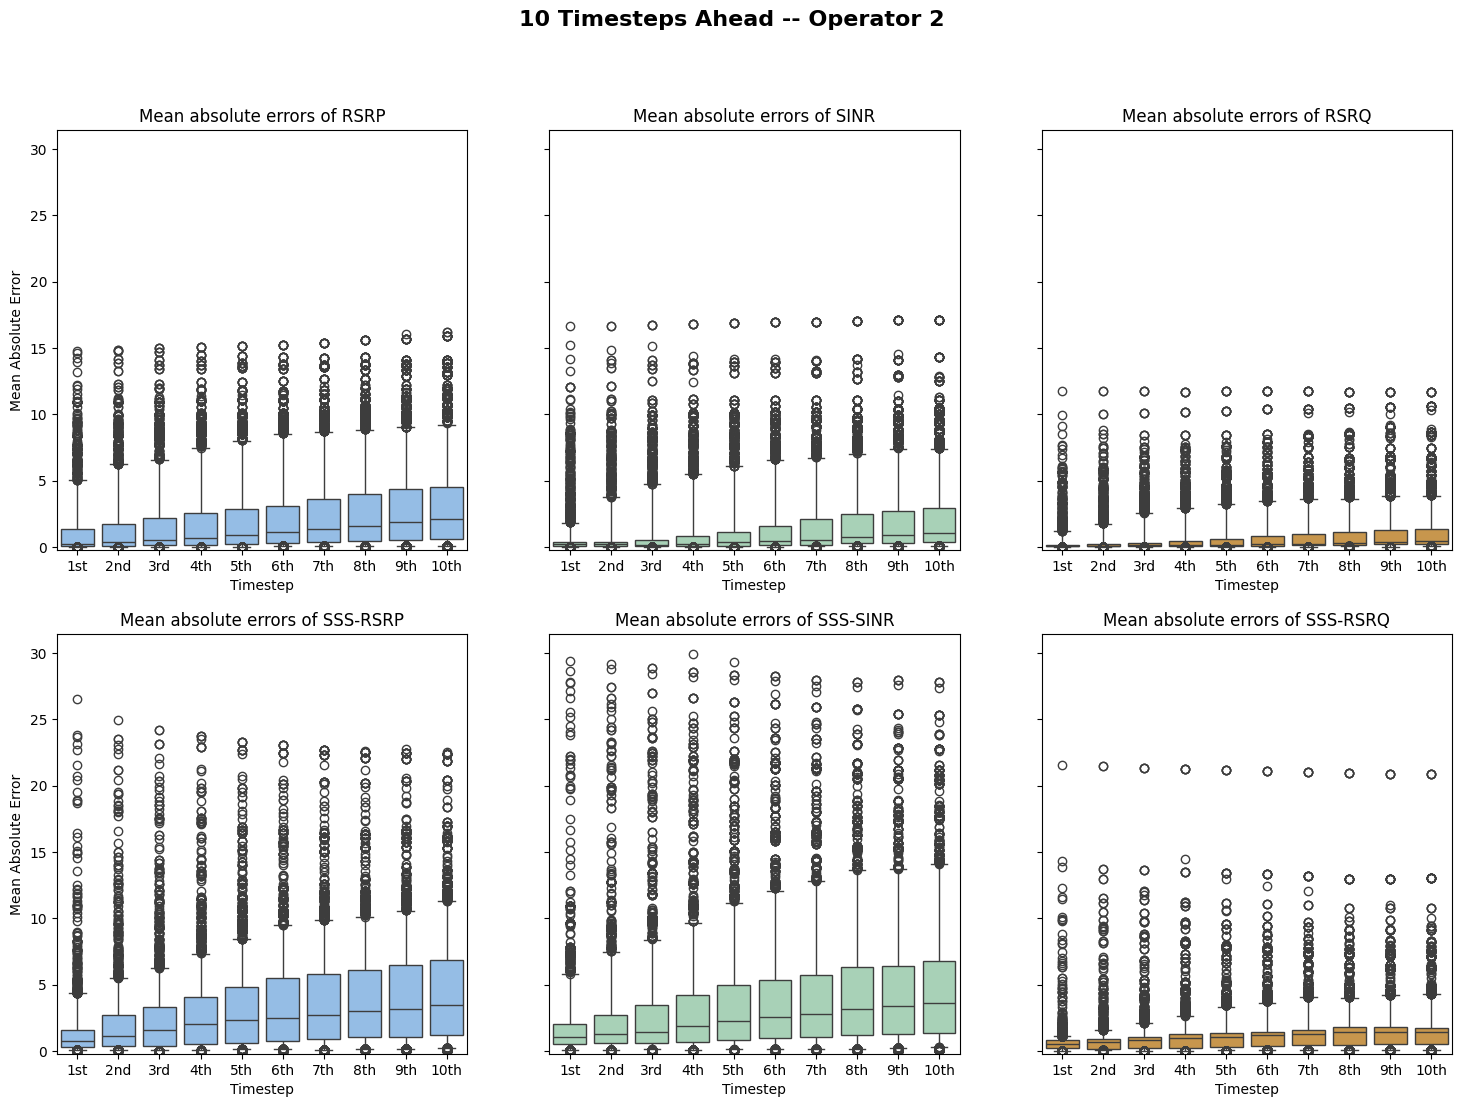

In [20]:
n_steps_in = 2
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [21]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.153,1.388,1.625,1.843,2.058,2.273,2.481,2.682,2.870,3.048
SINR,0.509,0.686,0.845,1.056,1.237,1.426,1.607,1.826,1.976,2.142
RSRQ,0.283,0.376,0.499,0.582,0.681,0.763,0.849,0.927,1.011,1.069
SSS-RSRP,1.300,1.882,2.277,2.738,3.156,3.537,3.741,3.965,4.163,4.368
SSS-SINR,1.702,2.207,2.613,3.055,3.469,3.756,4.032,4.417,4.489,4.725
SSS-RSRQ,0.592,0.718,0.866,1.021,1.108,1.218,1.321,1.458,1.492,1.506


### 3 steps back

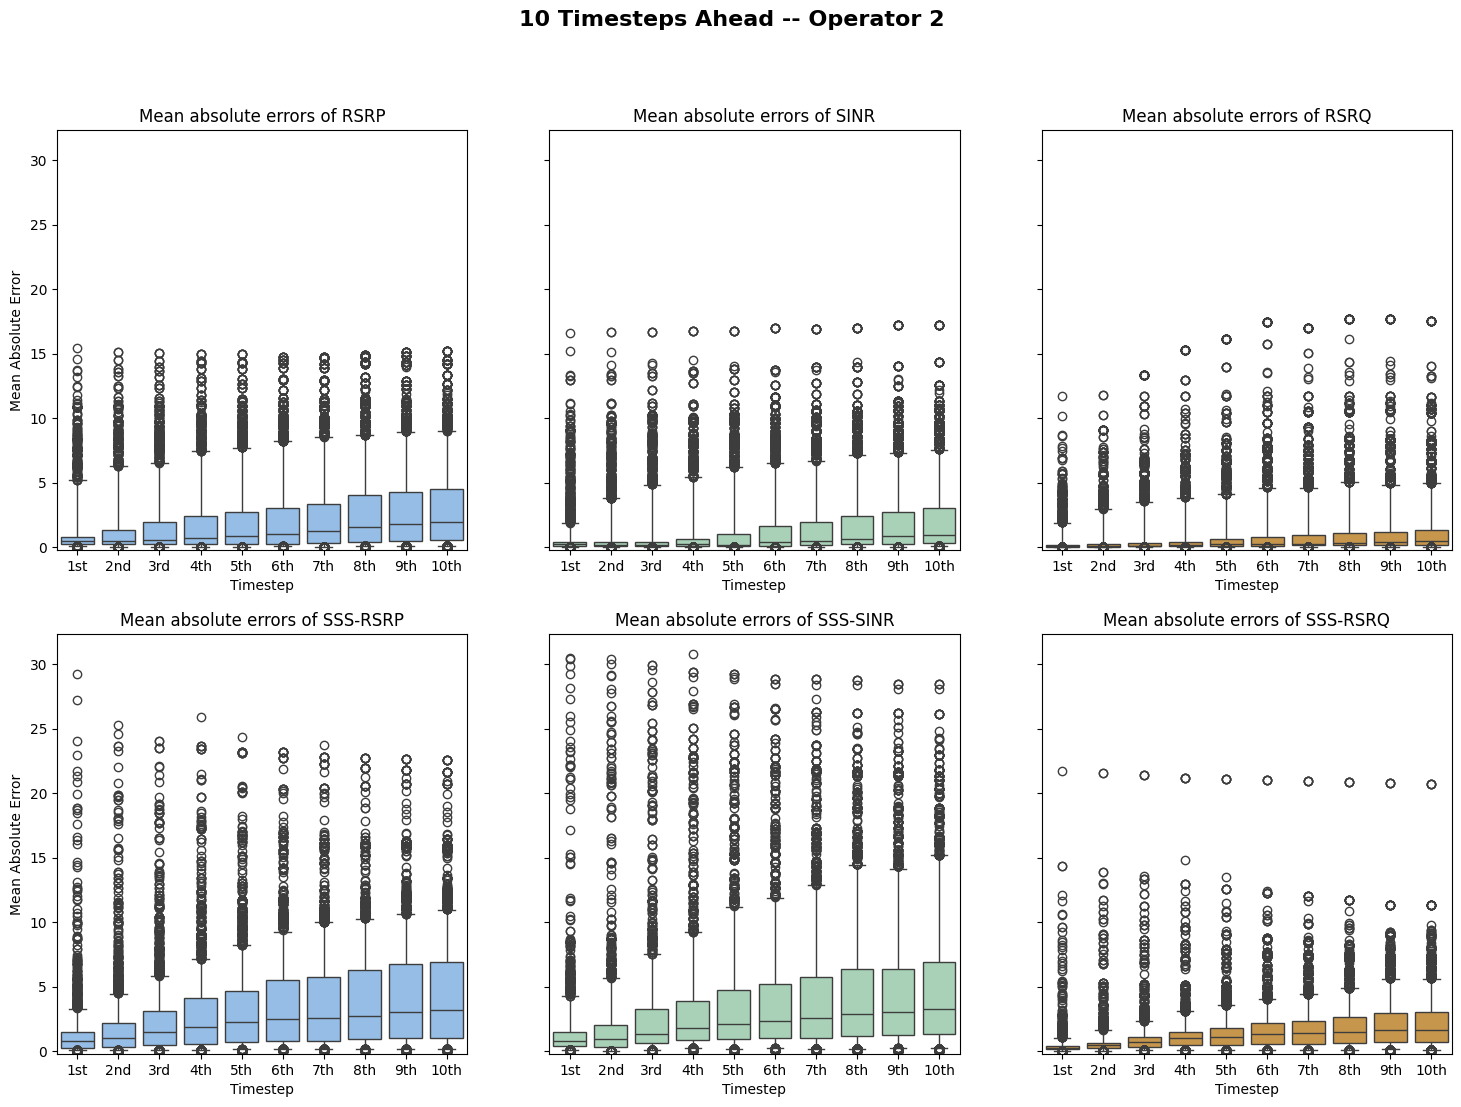

In [22]:
n_steps_in = 3
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [23]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.163,1.344,1.550,1.777,1.944,2.157,2.347,2.587,2.747,2.922
SINR,0.518,0.671,0.830,1.006,1.170,1.435,1.560,1.776,1.958,2.080
RSRQ,0.318,0.482,0.620,0.743,0.840,0.937,0.986,1.077,1.138,1.179
SSS-RSRP,1.155,1.596,2.175,2.741,3.104,3.536,3.703,3.948,4.204,4.346
SSS-SINR,1.326,1.667,2.368,2.902,3.411,3.719,4.053,4.462,4.510,4.832
SSS-RSRQ,0.393,0.621,0.905,1.169,1.379,1.584,1.723,1.902,2.063,2.113


### 5 steps back

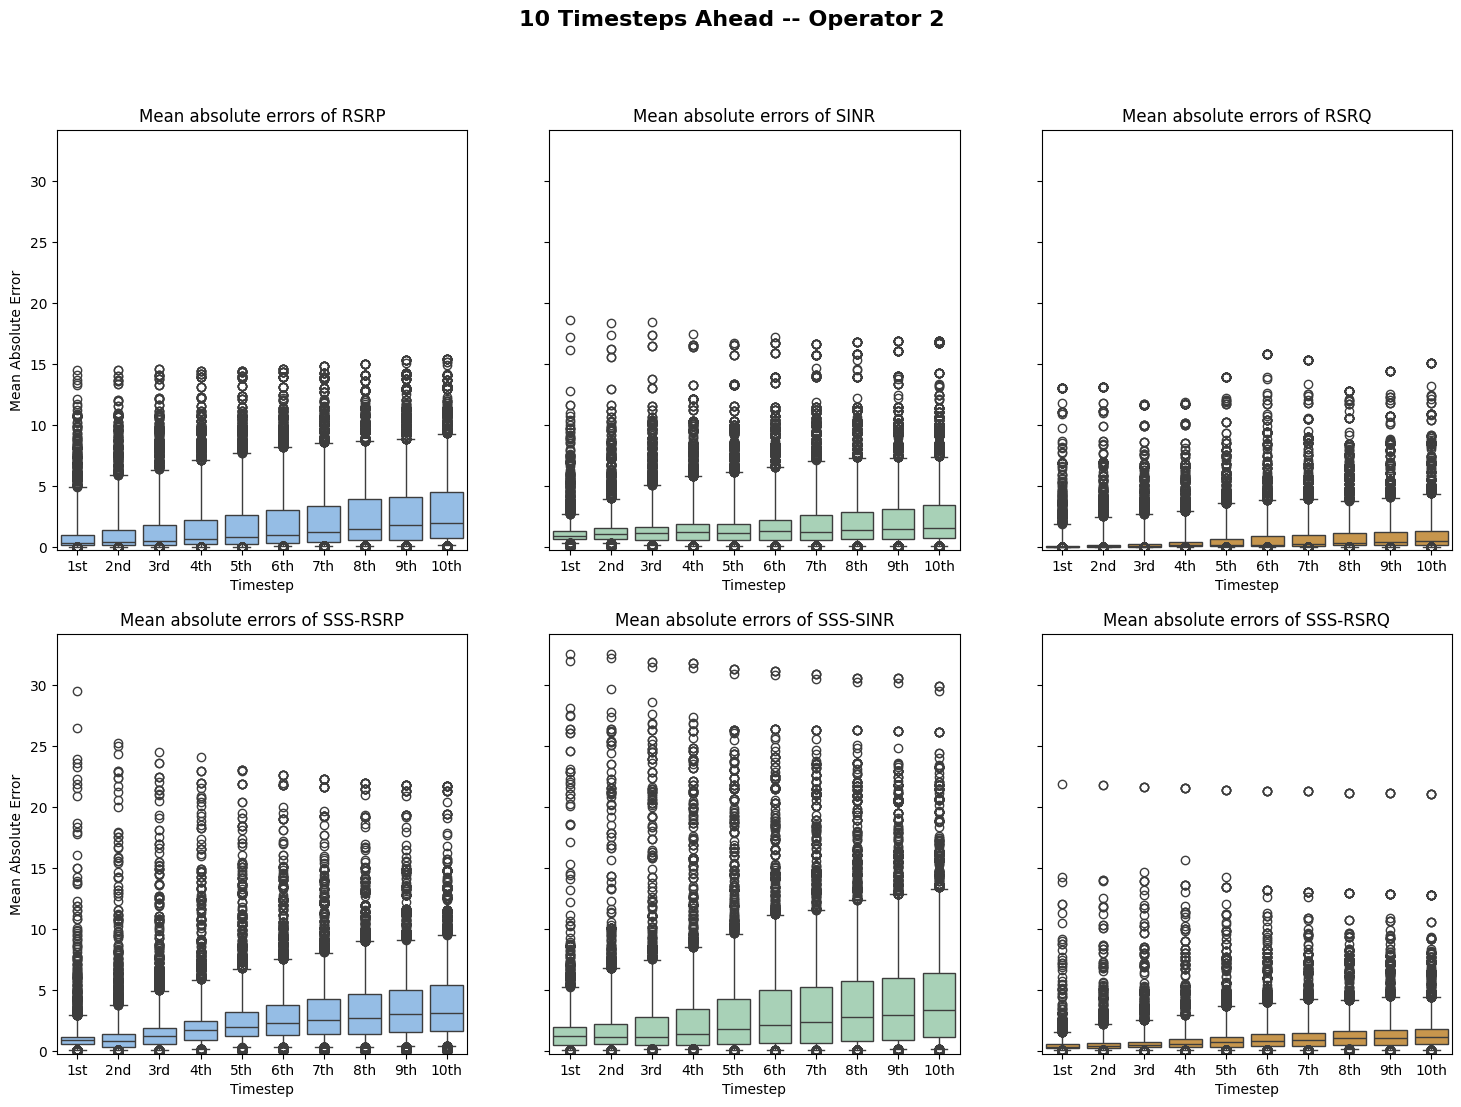

In [24]:
n_steps_in = 5
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [25]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.039,1.282,1.519,1.765,1.970,2.200,2.433,2.651,2.827,3.006
SINR,1.174,1.422,1.536,1.756,1.810,1.983,2.142,2.280,2.358,2.468
RSRQ,0.360,0.447,0.519,0.622,0.734,0.843,0.904,0.960,1.035,1.099
SSS-RSRP,1.133,1.244,1.716,2.160,2.624,3.004,3.263,3.496,3.642,3.874
SSS-SINR,1.681,1.949,2.270,2.602,3.033,3.427,3.633,3.979,4.165,4.469
SSS-RSRQ,0.516,0.669,0.769,0.951,1.074,1.204,1.324,1.407,1.474,1.542


### 10 steps back

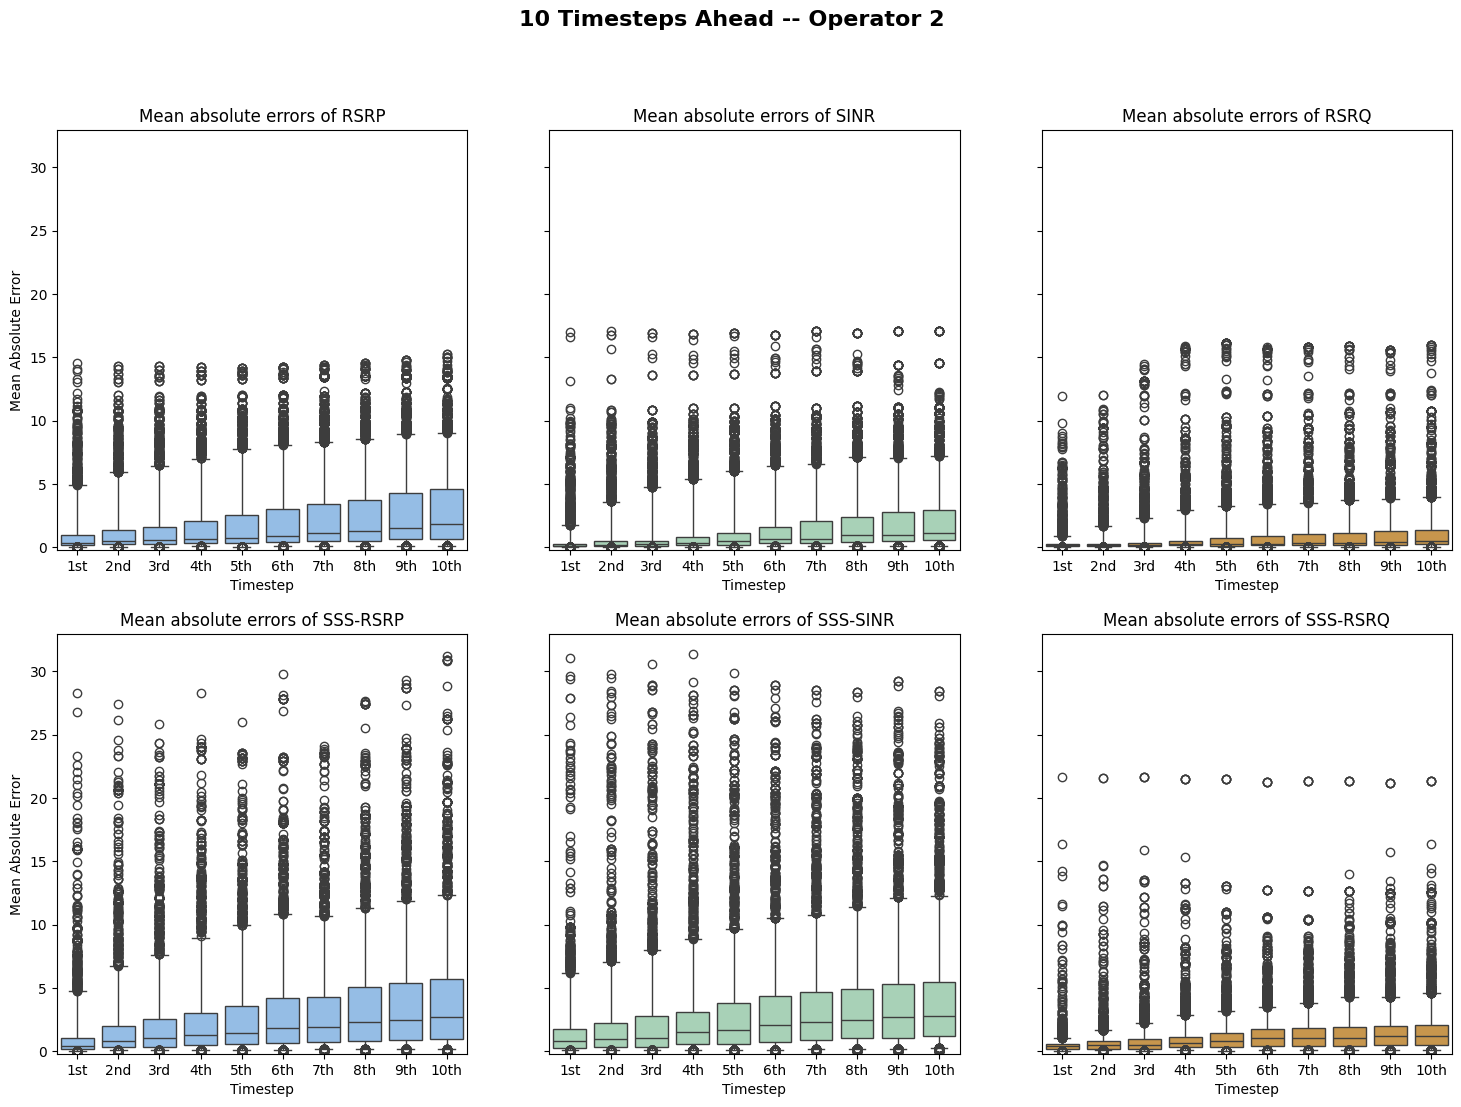

In [26]:
n_steps_in = 10
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [27]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.040,1.321,1.523,1.738,1.925,2.140,2.382,2.537,2.743,2.923
SINR,0.428,0.662,0.841,1.060,1.279,1.521,1.663,1.884,2.006,2.166
RSRQ,0.328,0.411,0.557,0.677,0.761,0.829,0.925,0.985,1.032,1.116
SSS-RSRP,1.187,1.782,2.141,2.481,2.733,3.152,3.206,3.614,3.833,4.071
SSS-SINR,1.541,1.901,2.255,2.625,2.946,3.251,3.486,3.696,3.920,4.051
SSS-RSRQ,0.481,0.665,0.799,0.979,1.131,1.327,1.401,1.475,1.560,1.617


### 20 steps back

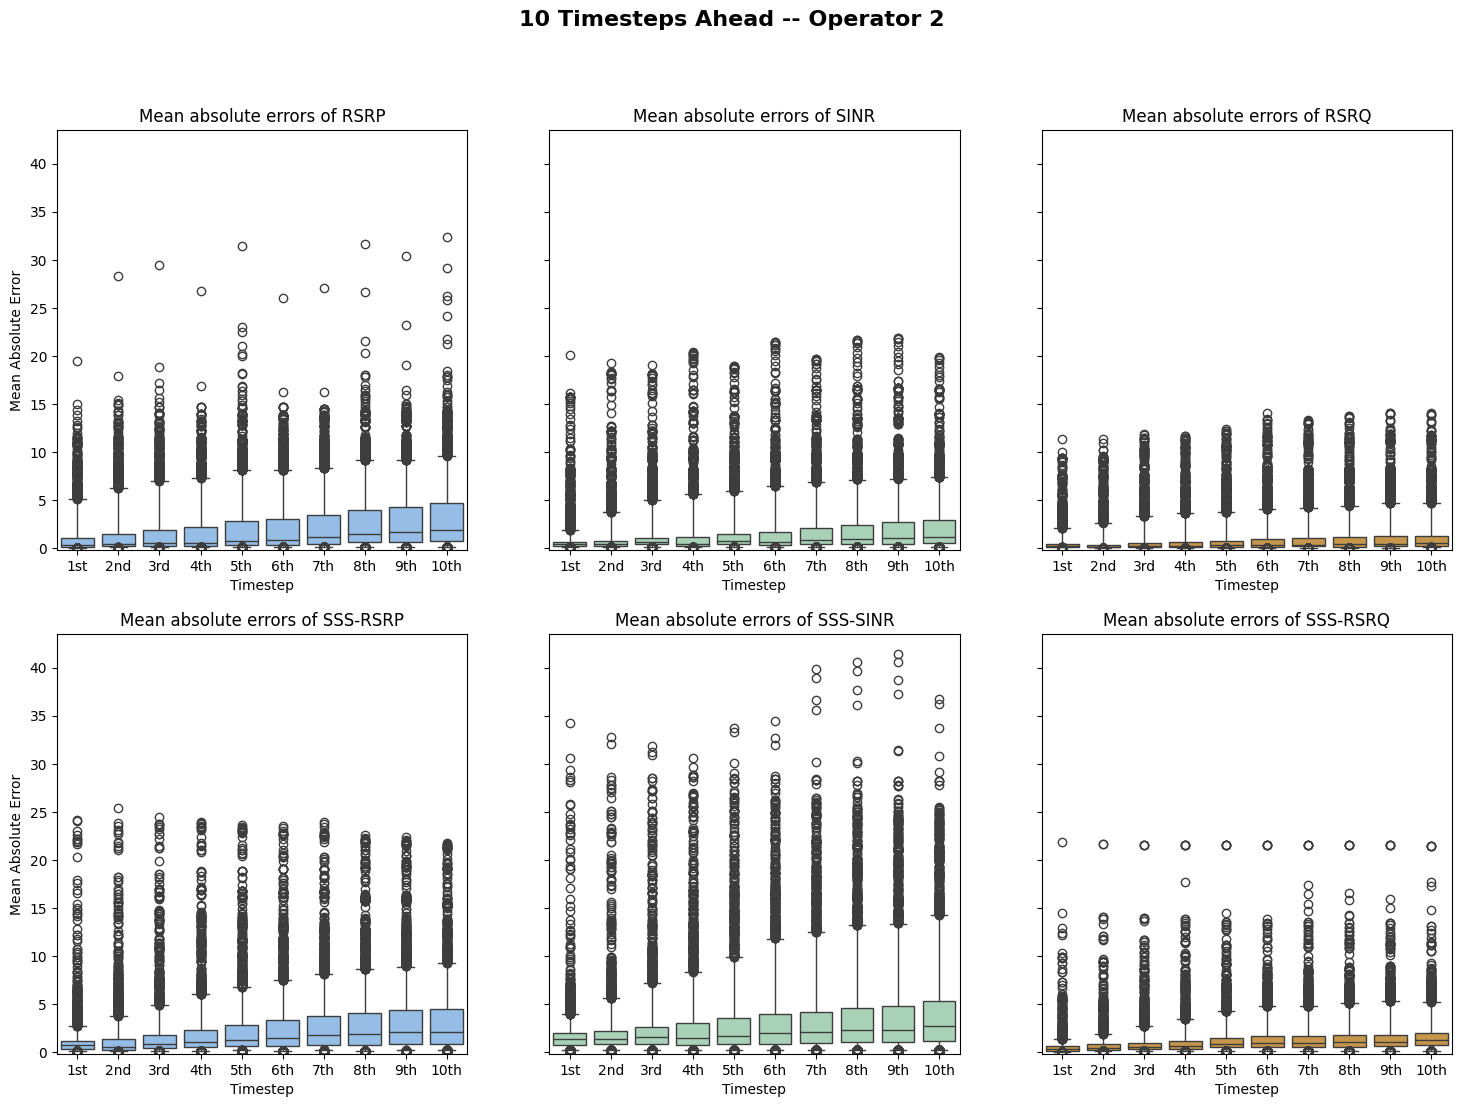

In [28]:
n_steps_in = 20
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [29]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.076,1.333,1.577,1.711,2.051,2.116,2.370,2.687,2.815,3.081
SINR,0.673,0.892,1.147,1.218,1.516,1.586,1.769,1.903,2.062,2.198
RSRQ,0.491,0.525,0.654,0.715,0.802,0.897,0.948,1.006,1.078,1.117
SSS-RSRP,0.991,1.131,1.481,1.845,2.145,2.445,2.710,2.869,3.046,3.112
SSS-SINR,1.652,2.004,2.399,2.603,2.955,3.284,3.497,3.749,3.843,4.187
SSS-RSRQ,0.489,0.687,0.854,1.030,1.250,1.378,1.419,1.493,1.530,1.639


### 30 steps back

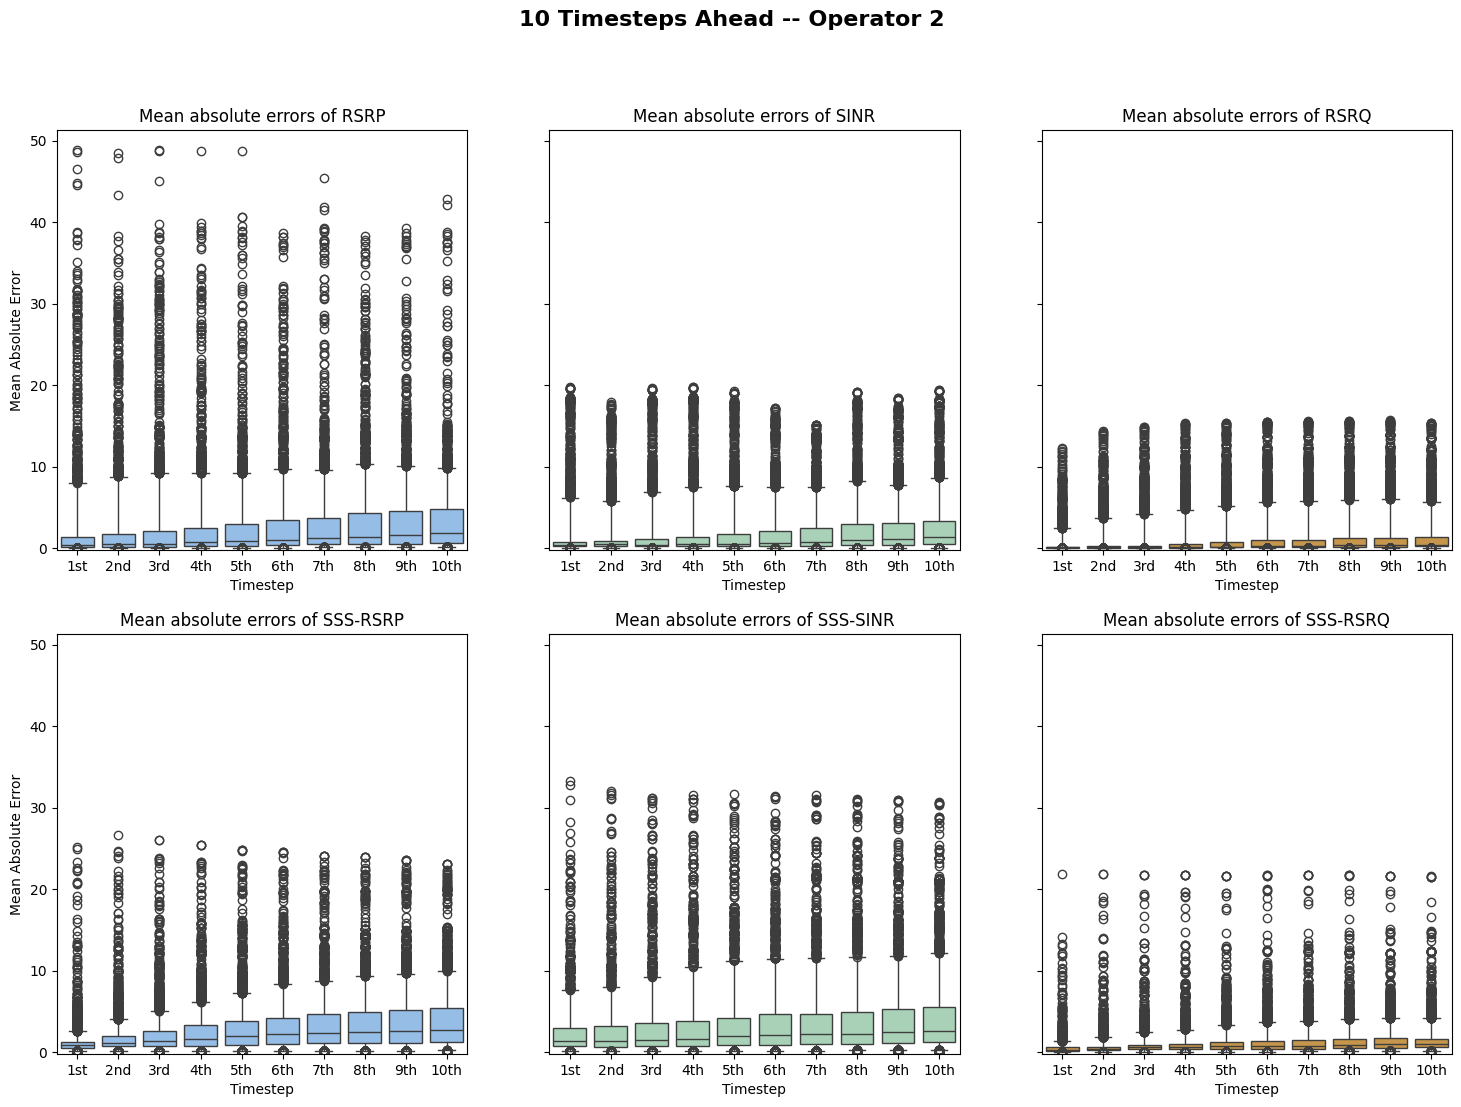

In [30]:
n_steps_in = 30
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [31]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.790,1.978,2.198,2.321,2.398,2.706,2.856,3.112,3.171,3.239
SINR,1.234,1.221,1.442,1.590,1.709,1.833,1.877,2.189,2.258,2.514
RSRQ,0.400,0.582,0.713,0.853,0.945,1.078,1.134,1.198,1.261,1.288
SSS-RSRP,1.118,1.641,2.000,2.420,2.746,2.993,3.282,3.438,3.587,3.746
SSS-SINR,2.321,2.493,2.791,2.992,3.286,3.403,3.530,3.676,3.807,3.986
SSS-RSRQ,0.503,0.650,0.843,0.936,1.105,1.204,1.242,1.337,1.416,1.394


### 40 steps back

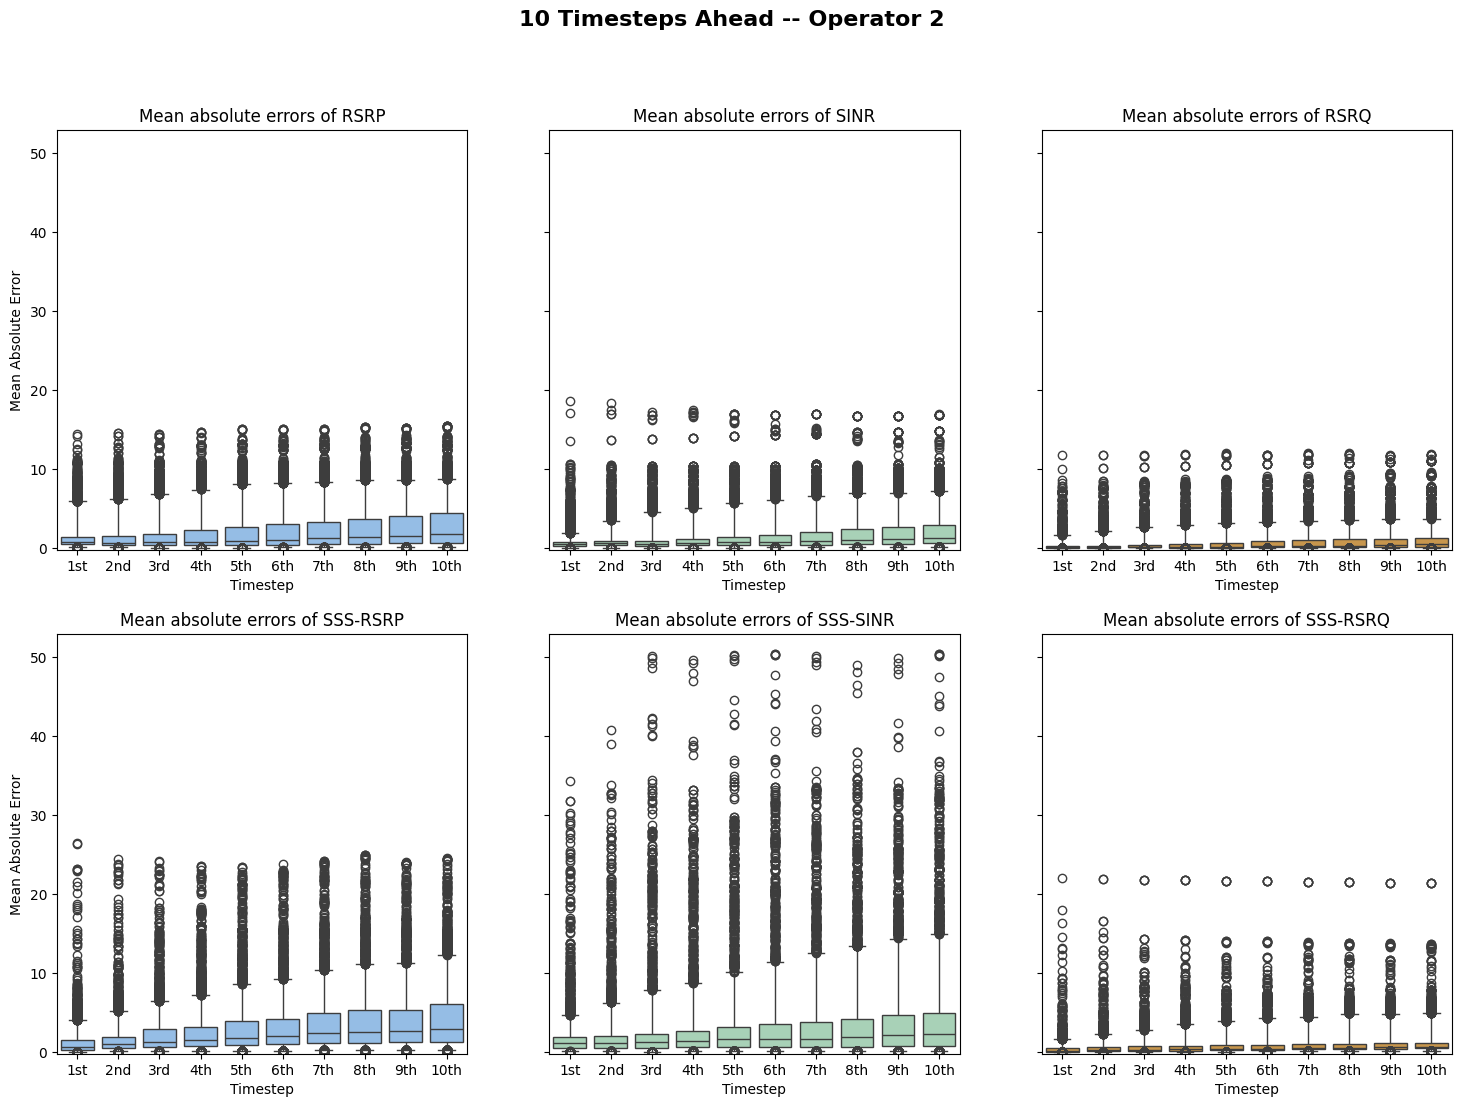

In [33]:
n_steps_in = 40
n_steps_out = 10

lstm_results = {}

for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_first_units=n_first_units, n_second_units=n_second_units)
            df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

mae_each_step = boxplot_timesteps(results=lstm_results, feature_comb=feature_comb, sss_feature_comb=sss_feature_comb, n_steps_out=n_steps_out, operator=operator)

In [34]:
mae_each_step

,1st,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
RSRP,1.458,1.533,1.696,1.860,2.035,2.210,2.385,2.544,2.711,2.868
SINR,0.770,0.939,1.062,1.243,1.443,1.589,1.765,1.918,2.045,2.200
RSRQ,0.382,0.478,0.582,0.632,0.716,0.800,0.855,0.929,0.996,1.052
SSS-RSRP,1.220,1.632,2.166,2.494,2.924,3.136,3.499,3.790,3.844,4.189
SSS-SINR,1.698,1.968,2.316,2.582,2.977,3.198,3.316,3.475,3.796,4.023
SSS-RSRQ,0.460,0.588,0.709,0.818,0.927,0.981,1.077,1.106,1.177,1.233
